# Step 1: Basic Evaluation

In our first step, we will be covering how we can perform basic evaluation. One of the great parts of FiftyOne is that once your data and model predictions are in FiftyOne, evaluation becomes easy, no matter if you are coming from different formats. Gone are the days of converting your YOLO styled predictions to COCO styled evaluation, FiftyOne handles all the conversions for you so you can focus on the task at hand.

Let’s take a look first at loading a common a dataset with predictions.

## Installation

Here are some packages that are needed to help run some of our demo code:

In [1]:
!pip install pycocotools

## Loading a Zoo Dataset for Evaluation

We will be loading the quickstart dataset from the Dataset Zoo. This dataset is a slice of MSCOCO and contains some preloaded predictions. If you are unsure how to load your own detection dataset, be sure to checkout our Getting Started with Detections

Once our dataset is loaded, we can start getting ready for model eval!

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("quickstart")

# View summary info about the dataset
print(dataset)

/home/stan/miniconda3/envs/voxel51/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset already downloaded
Loading existing dataset 'quickstart'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Name:        quickstart
Media type:  image
Num samples: 200
Persistent:  False
Tags:        []
Sample fields:
    id:                fiftyone.core.fields.ObjectIdField
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:        fiftyone.core.fields.DateTimeField
    last_modified_at:  fiftyone.core.fields.DateTimeField
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:        fiftyone.core.fields.FloatField
    predictions:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    mistakenness:      fiftyone.core.fields.FloatFi

Before we go further, let’s launch the FiftyOne App and use the GUI to explore the dataset visually:

In [3]:
session = fo.launch_app(dataset, auto=False)

Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port
Session launched. Run `session.show()` to open the App in a cell output.


## Evaluate Detections

Now that we have samples with ground truth and predicted objects, let’s use FiftyOne to evaluate the quality of the detections.

FiftyOne provides a powerful evaluation API that contains a collection of methods for performing evaluation of model predictions. Since we’re working with object detections here, we’ll use detection evaluation

We can run evaluation on our samples via evaluate_detections(). Note that this method is available on both the Dataset and DatasetView classes, which means that we can run evaluation on subsets of our dataset as well.

By default, this method will use the COCO evaluation protocol, plus some extra goodies that we will use later.

In [10]:
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |█████████████████| 200/200 [9.0s elapsed, 0s remaining, 16.0 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 200/200 [3.2s elapsed, 0s remaining, 45.4 samples/s]      


## Analyzing Results

The results object returned by the evaluation routine provides a number of convenient methods for analyzing our predictions.

For example, let’s print a classification report for the top-10 most common classes in the dataset:

In [13]:
# Get the 10 most common classes in the dataset
counts = dataset.count_values("ground_truth.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# classes = sorted(counts, key=counts.get, reverse=True)

# Print a classification report for the top-10 classes
results.print_report(classes=classes_top10)

               precision    recall  f1-score   support

       person       0.52      0.94      0.67       716
         kite       0.59      0.88      0.71       140
          car       0.18      0.80      0.29        61
         bird       0.65      0.78      0.71       110
       carrot       0.09      0.74      0.16        47
         boat       0.09      0.46      0.16        37
    surfboard       0.17      0.73      0.28        30
     airplane       0.36      0.83      0.50        24
traffic light       0.32      0.79      0.45        24
        chair       0.07      0.48      0.13        23

    micro avg       0.37      0.87      0.52      1212
    macro avg       0.30      0.74      0.41      1212
 weighted avg       0.47      0.87      0.60      1212



We can also grab the mean average-precision (mAP) of our model as well:

In [8]:
print(results.mAP())

0.3957238101325776


## Evaluate Subsets

As mentioned before, we can evaluate DatasetViews as well! Let’s evaluate only where our model is highly confident. First we will create a high confidence view, then evaluate with evaluate_detections() again. See using Dataset Views for full details on matching, filtering, or sorting detections.

In [11]:
from fiftyone import ViewField as F

# Only contains detections with confidence >= 0.75
high_conf_view = dataset.filter_labels("predictions", F("confidence") > 0.75, only_matches=False)

# Print some information about the view
print(high_conf_view)

Dataset:     quickstart
Media type:  image
Num samples: 200
Sample fields:
    id:                fiftyone.core.fields.ObjectIdField
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:        fiftyone.core.fields.DateTimeField
    last_modified_at:  fiftyone.core.fields.DateTimeField
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:        fiftyone.core.fields.FloatField
    predictions:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    mistakenness:      fiftyone.core.fields.FloatField
    possible_missing:  fiftyone.core.fields.IntField
    possible_spurious: fiftyone.core.fields.IntField
    eval_tp:           fiftyone.core.fields.IntField
    eval_fp:           fiftyone.core

We can check out our new view in the session before we run evaluation:

In [12]:
session.view = high_conf_view

Just like before, lets run evaluation. Be sure to change the eval_key to a new name this time!

In [14]:
results = high_conf_view.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval_high_conf",
    compute_mAP=True,
)

# Print the same report to see the difference
results.print_report(classes=classes_top10)
print(results.mAP())

Evaluating detections...
 100% |█████████████████| 200/200 [1.7s elapsed, 0s remaining, 88.5 samples/s]          
Performing IoU sweep...
 100% |█████████████████| 200/200 [1.3s elapsed, 0s remaining, 129.9 samples/s]         
               precision    recall  f1-score   support

       person       0.85      0.72      0.78       412
         kite       0.84      0.68      0.75        91
          car       0.74      0.51      0.60        61
         bird       0.91      0.48      0.63        64
       carrot       0.58      0.40      0.47        47
         boat       0.62      0.35      0.45        37
    surfboard       0.63      0.40      0.49        30
     airplane       0.90      0.79      0.84        24
traffic light       0.88      0.62      0.73        24
        chair       0.50      0.22      0.30        23

    micro avg       0.81      0.62      0.70       813
    macro avg       0.74      0.52      0.61       813
 weighted avg       0.80      0.62      0.69       813



## Evaluate for Classification

Evaluation is just as easy for classification tasks. Once you have loaded up your dataset and model predictions, you can start with dataset.evaluate_classifications()

If you need a refresher on how to work with classification datasets, head over to Getting Started with Classifications!

100%|██████████| 170M/170M [00:12<00:00, 13.6MB/s] 


 100% |█████████████| 10000/10000 [1.5s elapsed, 0s remaining, 6.7K samples/s]         
Dataset info written to '/home/stan/fiftyone/cifar10/info.json'
Loading 'cifar10' split 'test'
 100% |█████████████| 10000/10000 [2.7s elapsed, 0s remaining, 3.7K samples/s]      
Dataset 'cifar10-test' created



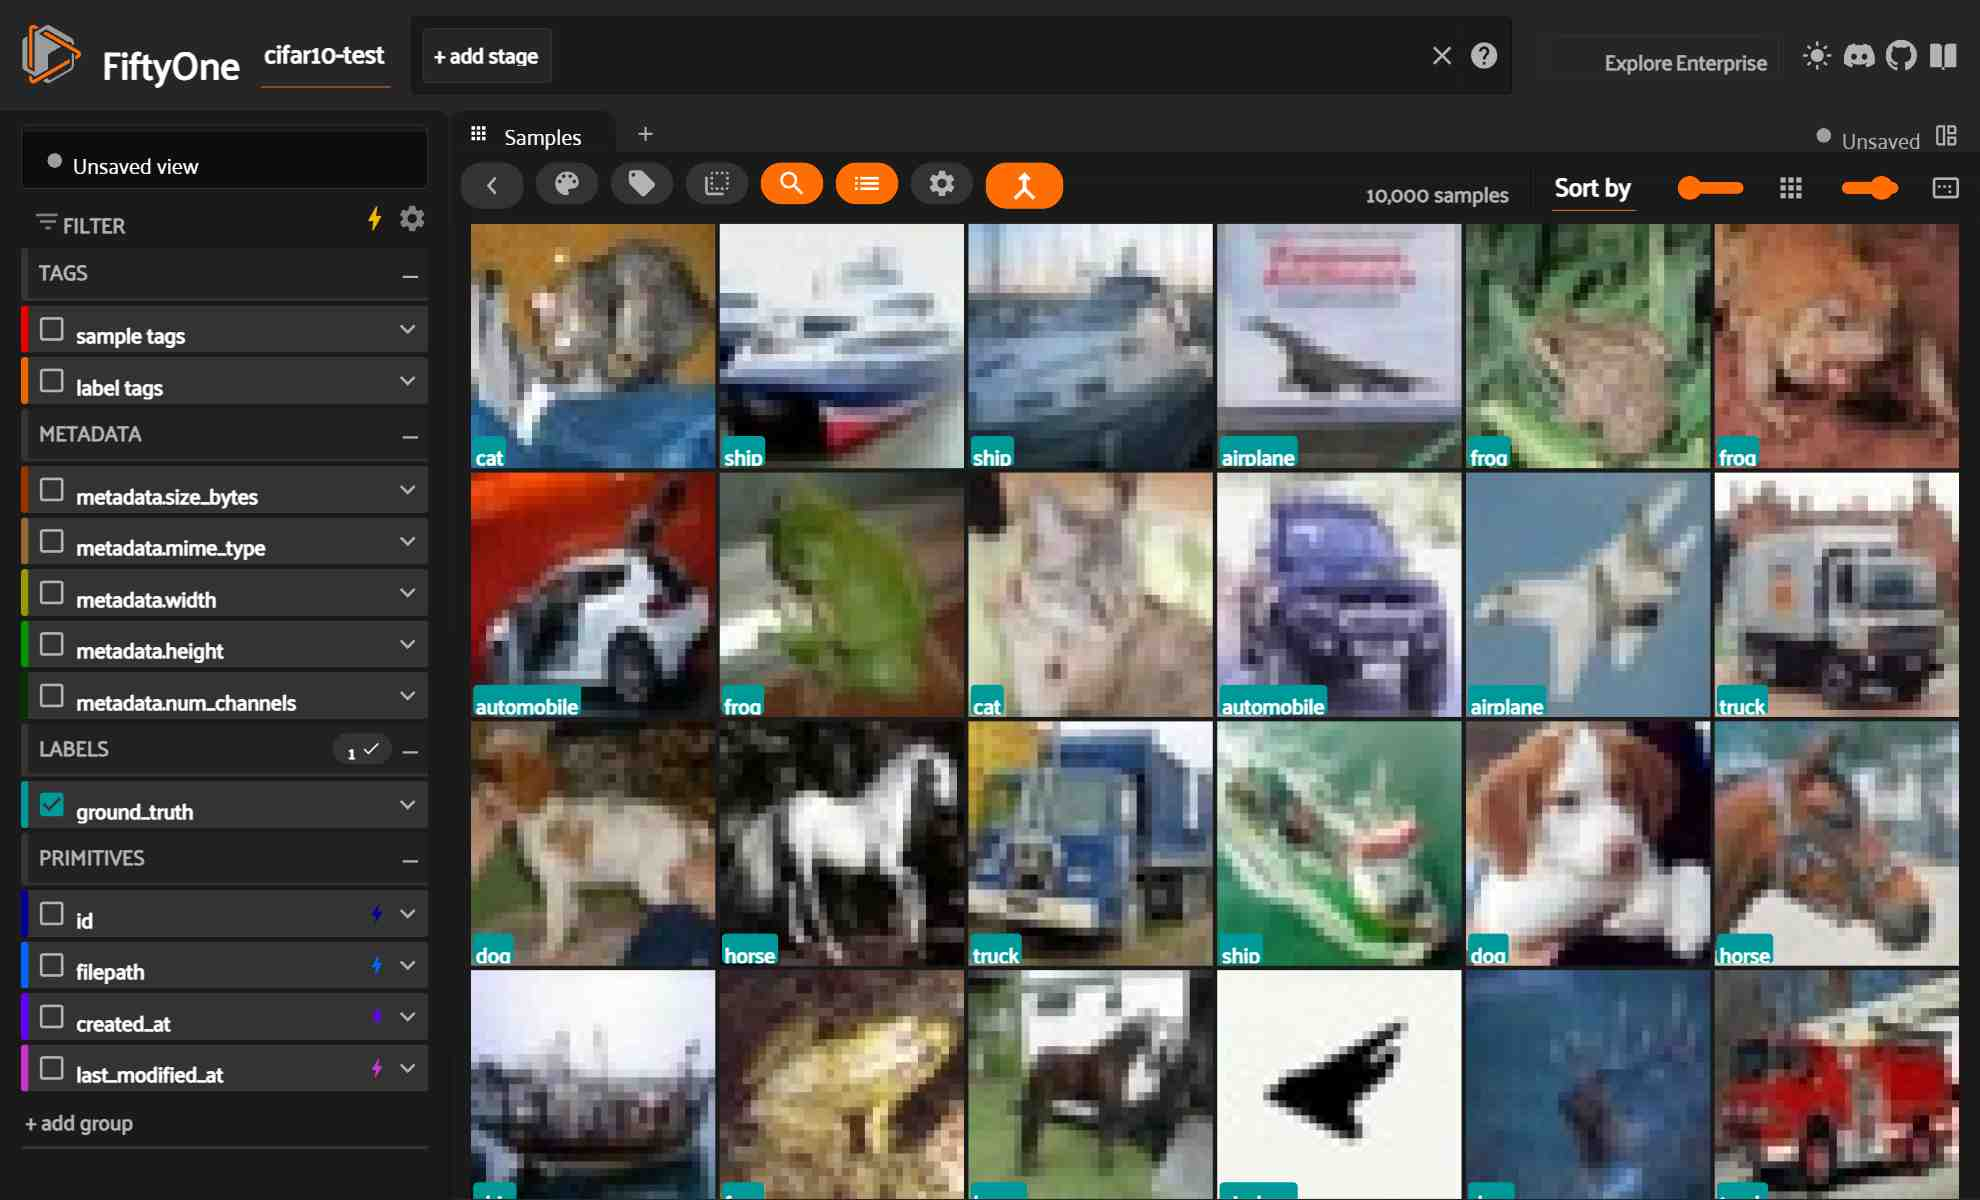

In [15]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("cifar10", split="test")

session = fo.launch_app(dataset)

In [20]:
import fiftyone.zoo as foz

classes = ["horse", "truck", "deer", "automobile", "bird", "ship", "cat", "dog", "frog", "airplane"]

clip = foz.load_zoo_model(
    "clip-vit-base32-torch",
    classes=classes,
)

first_5_samples = dataset.limit(5)

first_5_samples.apply_model(clip, label_field="clip")

results = first_5_samples.evaluate_classifications(pred_field="clip", gt_field="ground_truth", eval_key="eval")

# Print the same report to see the difference
results.print_report()

 100% |█████████████████████| 5/5 [446.2ms elapsed, 0s remaining, 11.2 samples/s]     
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00         1
        bird       0.00      0.00      0.00         0
         cat       1.00      1.00      1.00         1
        frog       1.00      1.00      1.00         1
        ship       1.00      1.00      1.00         2

    accuracy                           0.80         5
   macro avg       0.60      0.60      0.60         5
weighted avg       0.80      0.80      0.80         5



## Evaluate for Segmentation

The last basic form of evaluation we will cover is evaluating segmentations!

There are two popular forms of segmentations, Instance Segmentation and Semantic Segmentation. In FiftyOne, instance segmentation is stored in fo.Detections and semantic segmentations are stored in fo.Segmentations. We will cover how to evaluate both.

If you need a refresher on how to work with segmentation datasets, head over to Getting Started with Segmentations!

Once your dataset is prepped and ready with ground_truth and predicted segmentations, you can start evaluation!

Found annotations at '/home/stan/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████████| 25/25 [117.2ms elapsed, 0s remaining, 213.3 samples/s]    
Dataset 'coco-2017-validation-25' created



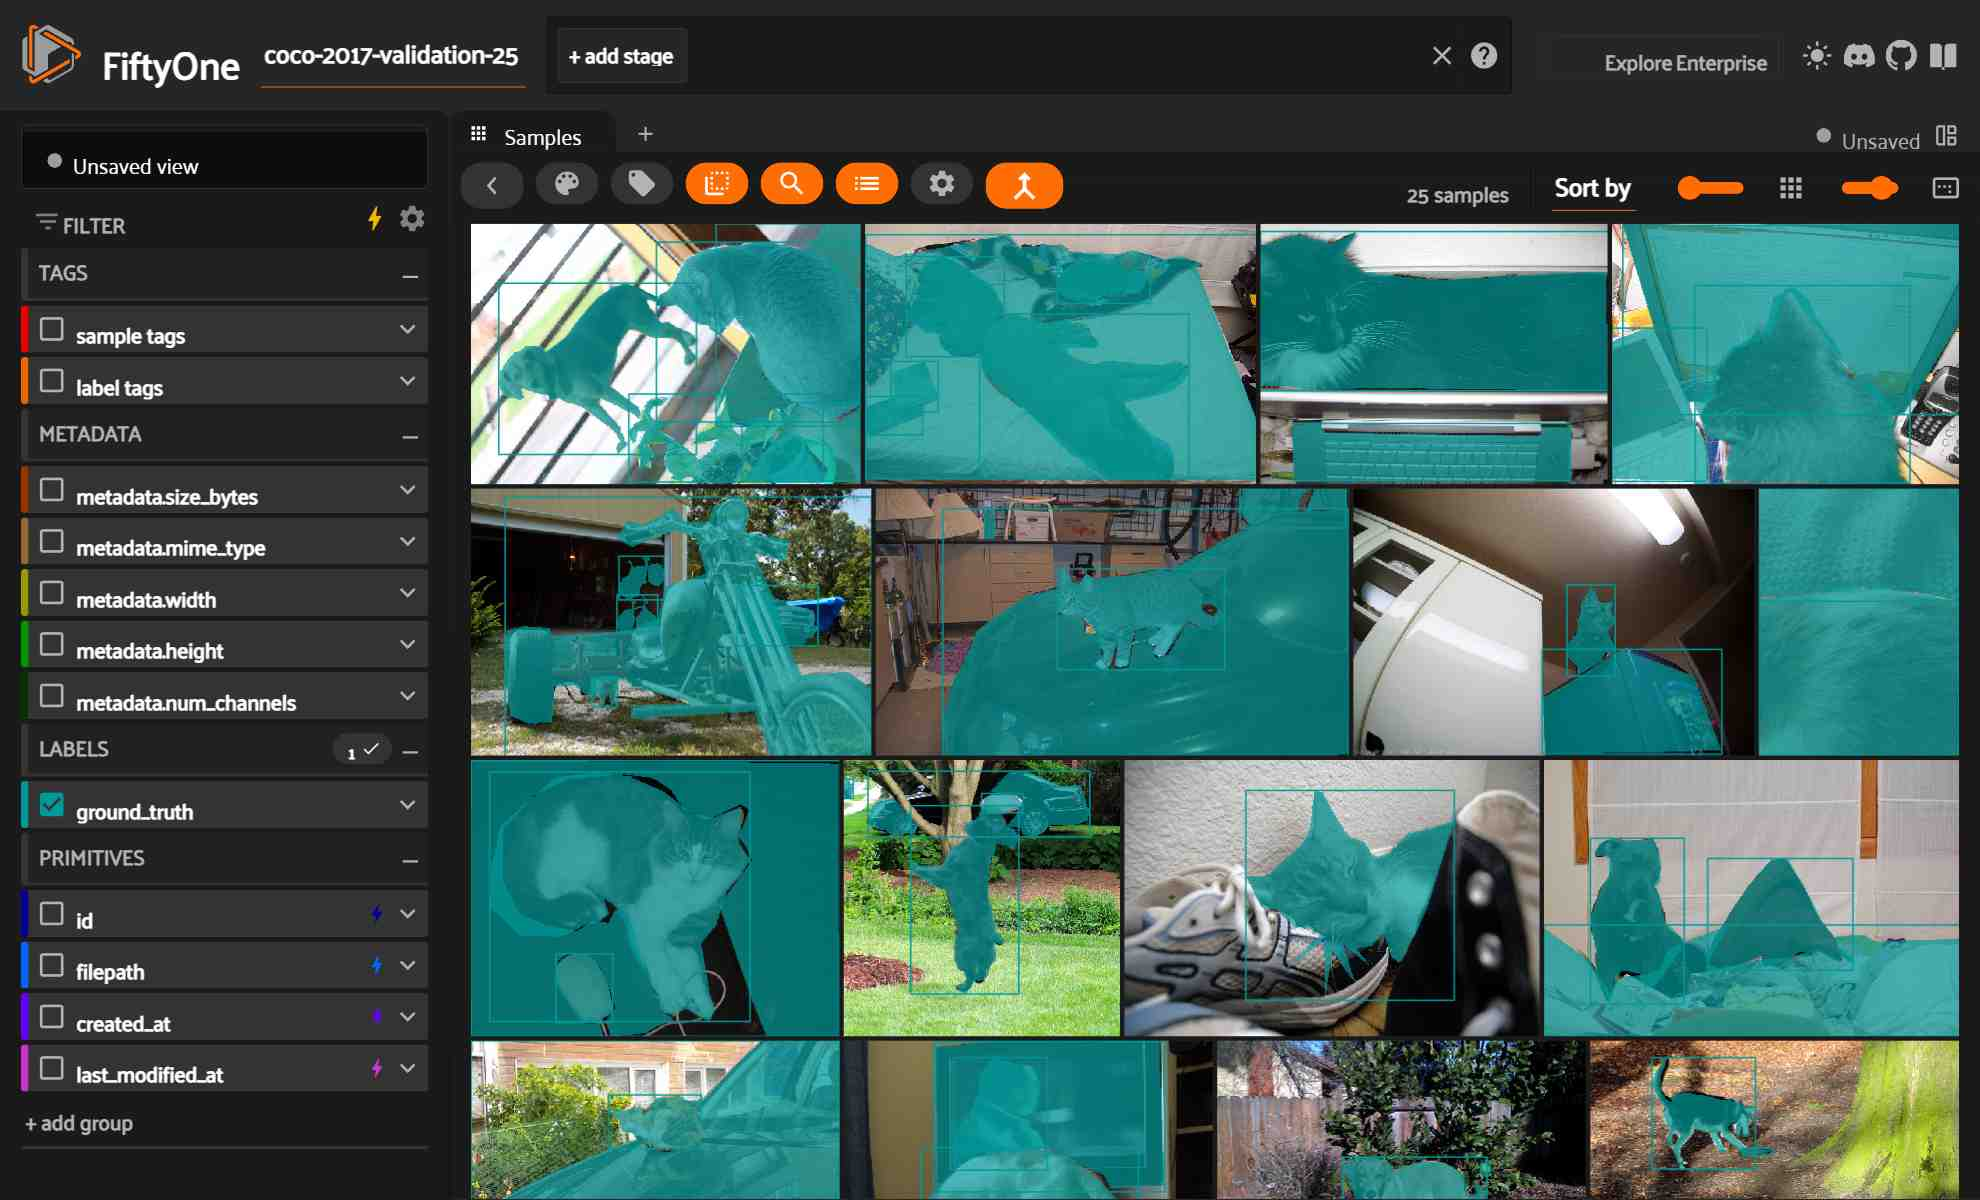

In [ ]:
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["segmentations"],
    classes=["cat", "dog"],
    max_samples=25,
)

session.dataset = dataset

In [22]:
from ultralytics import YOLO

# Use the YOLO model to add some predictions to the dataset
model = YOLO("yolo11s-seg.pt")

dataset.apply_model(model, label_field="instances")

 100% |███████████████████| 25/25 [1.3s elapsed, 0s remaining, 19.3 samples/s]      


With our model and predictions loaded, lets run evaluation with detection.evaluate_detection().

In [23]:
results = dataset.evaluate_detections(
    "instances",
    gt_field="ground_truth",
    eval_key="inst_eval",
    use_masks=True,
    compute_mAP=True,
)

# Print the same report to see the difference
results.print_report()
print(results.mAP())

Evaluating detections...
 100% |███████████████████| 25/25 [264.1ms elapsed, 0s remaining, 94.7 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 25/25 [222.8ms elapsed, 0s remaining, 112.2 samples/s]      
              precision    recall  f1-score   support

         bed       1.00      0.50      0.67         4
       bench       0.50      1.00      0.67         1
     bicycle       0.75      1.00      0.86         3
        bird       0.00      0.00      0.00         1
        book       0.67      1.00      0.80         2
      bottle       1.00      1.00      1.00         2
        bowl       1.00      1.00      1.00         1
         car       0.50      1.00      0.67         4
         cat       0.95      1.00      0.97        18
       chair       0.00      0.00      0.00         1
       couch       0.50      0.50      0.50         2
         cup       1.00      1.00      1.00         1
dining table       0.00      0.00      0.00         1
         dog     

## Semantic Segmentation Evaluation

Now let’s look at an example of semantic segmentation. We can easily convert our instance segmentation dataset to semantic masks using to_segmentation(). After we convert our ground_truth and instances fields, we can evaluate our new masks! Let’s convert now:


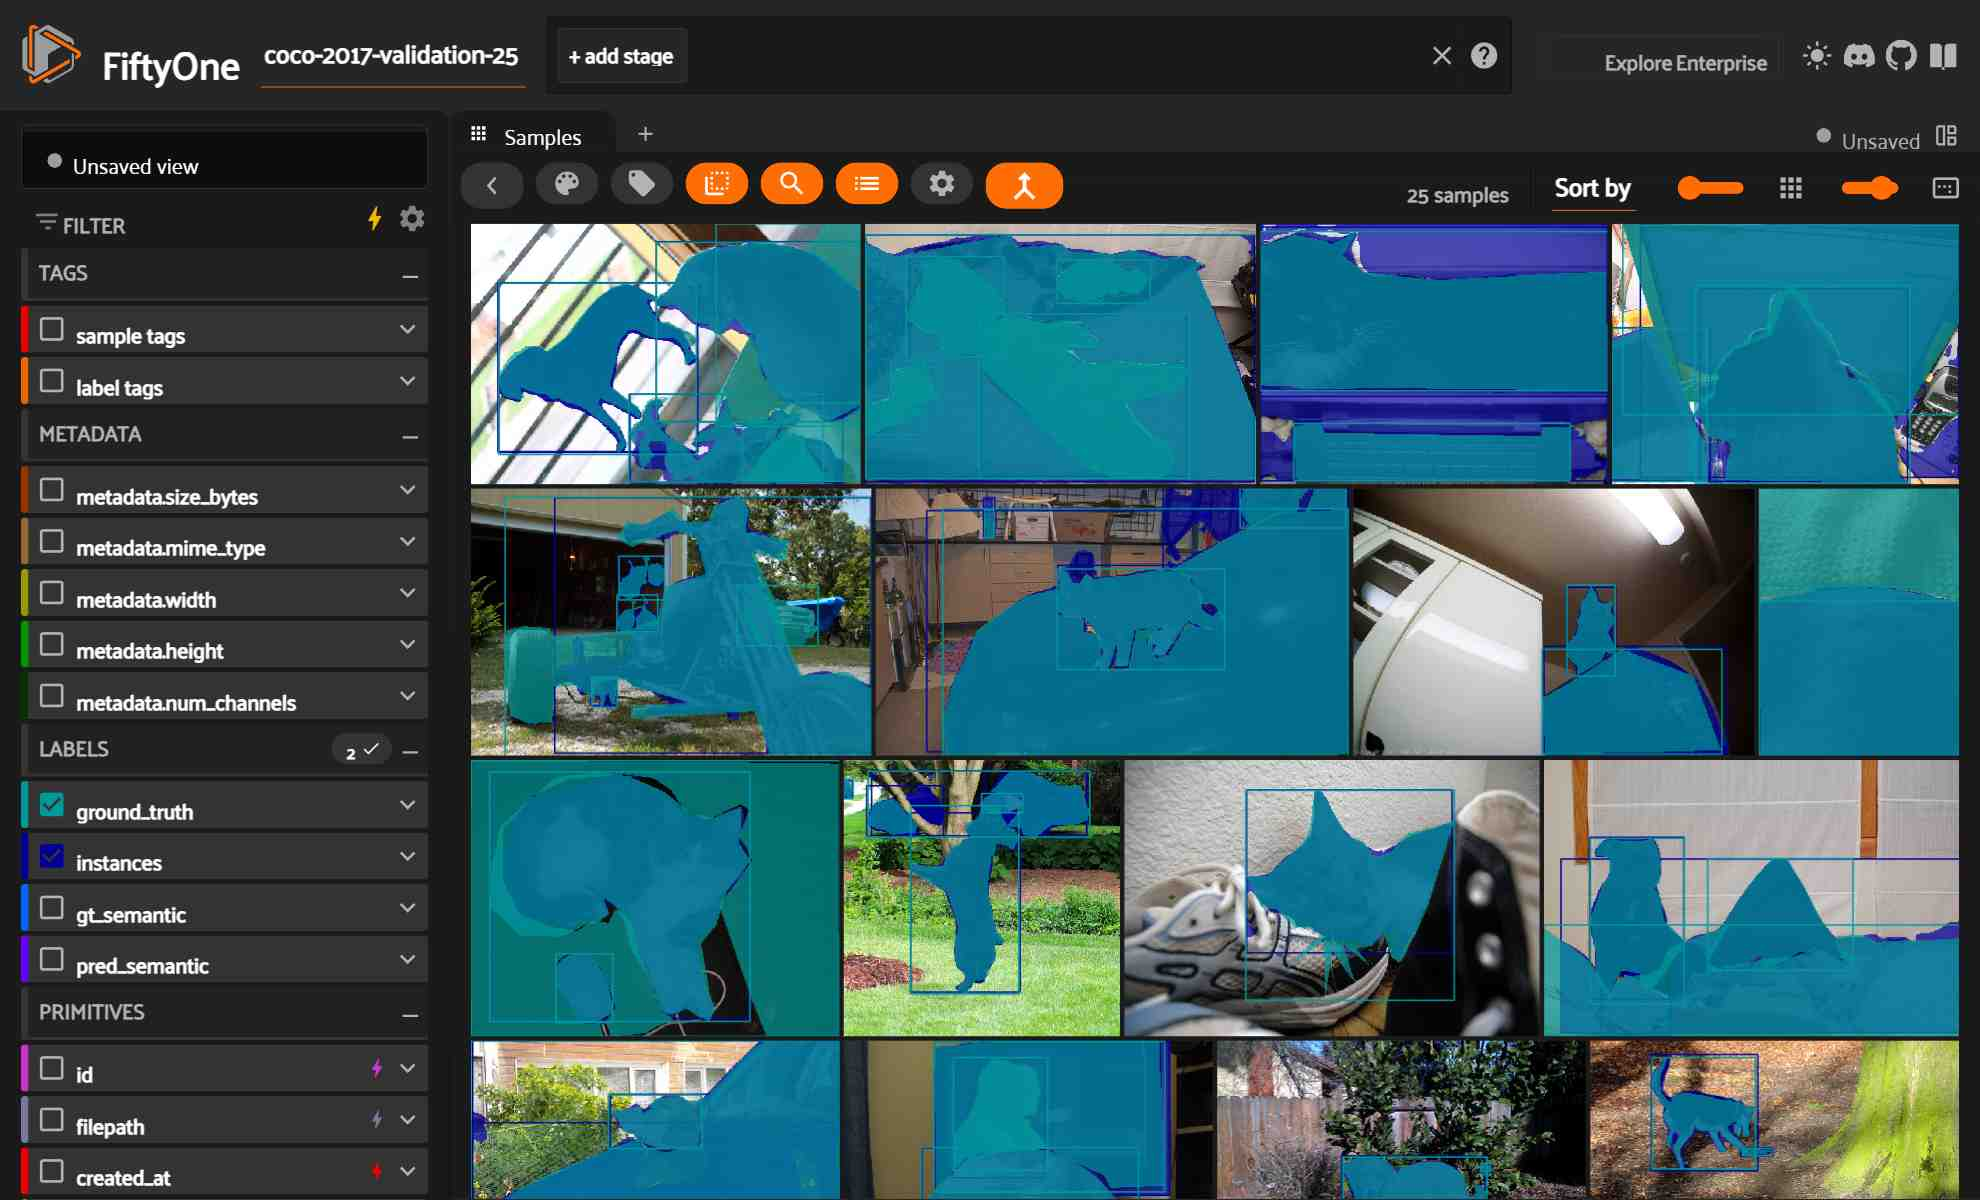

In [ ]:
dataset.compute_metadata()
for sample in dataset:

    detections = sample["ground_truth"]
    segmentation = detections.to_segmentation(
        frame_size=(sample.metadata.width, sample.metadata.height),
        mask_targets={1: "cat", 2: "dog"},
    )
    sample["gt_semantic"] = segmentation

    detections = sample["instances"]
    segmentation = detections.to_segmentation(
        frame_size=(sample.metadata.width, sample.metadata.height),
        mask_targets={1: "cat", 2: "dog"},
    )
    sample["pred_semantic"] = segmentation
    sample.save()

session.show()

Finally, we can evaluate our semantic segmentations with dataset.evaluate_segmentations():

In [25]:
results = dataset.evaluate_segmentations("gt_semantic", "pred_semantic", eval_key="seg_eval")
results.print_report()

Computing possible mask values...
 100% |███████████████████| 25/25 [355.4ms elapsed, 0s remaining, 70.3 samples/s]      
Evaluating segmentations...
 100% |███████████████████| 25/25 [215.1ms elapsed, 0s remaining, 116.2 samples/s]      
              precision    recall  f1-score   support

           1       0.96      0.96      0.96 1164790.0
           2       0.94      0.94      0.94  286010.0

   micro avg       0.96      0.95      0.96 1450800.0
   macro avg       0.95      0.95      0.95 1450800.0
weighted avg       0.96      0.95      0.96 1450800.0



# Step 2: Analyzing with Model Evaluation Panel

In our last step we showed some basic ways on how to evaluate models. In this step, we will show how to take it even further with the Model Eval Panel in the app. With the Model Eval Panel you can:

- See all evaluation runs on a dataset
- View summary statistics of each run
- Filter dataset based on FP, TP, and more
- Analyze class-wise evaluation metrics and filter based on them
- View confusion matrices and histograms of evaluation results

Let’s hop into an example to see how to get started!

In [26]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("quickstart")

# View summary info about the dataset
print(dataset)

Dataset already downloaded
Loading existing dataset 'quickstart'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Name:        quickstart
Media type:  image
Num samples: 200
Persistent:  False
Tags:        []
Sample fields:
    id:                fiftyone.core.fields.ObjectIdField
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:        fiftyone.core.fields.DateTimeField
    last_modified_at:  fiftyone.core.fields.DateTimeField
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:        fiftyone.core.fields.FloatField
    predictions:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    mistakenness:      fiftyone.core.fields.FloatFi

Let’s quickly rerun evaluation in case we do not have it from the previous step:

In [27]:
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |█████████████████| 200/200 [9.5s elapsed, 0s remaining, 15.7 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 200/200 [3.3s elapsed, 0s remaining, 45.7 samples/s]      


In [28]:
from fiftyone import ViewField as F

# Only contains detections with confidence >= 0.75
high_conf_view = dataset.filter_labels("predictions", F("confidence") > 0.75, only_matches=False)

results = high_conf_view.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval_high_conf",
    compute_mAP=True,
)

Evaluating detections...
 100% |█████████████████| 200/200 [1.7s elapsed, 0s remaining, 95.7 samples/s]          
Performing IoU sweep...
 100% |█████████████████| 200/200 [1.5s elapsed, 0s remaining, 110.4 samples/s]         


In [29]:
dataset.load_evaluation_view("eval")

Name:        quickstart
Media type:  image
Num samples: 200
Persistent:  False
Tags:        []
Sample fields:
    id:                fiftyone.core.fields.ObjectIdField
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:        fiftyone.core.fields.DateTimeField
    last_modified_at:  fiftyone.core.fields.DateTimeField
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:        fiftyone.core.fields.FloatField
    predictions:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    mistakenness:      fiftyone.core.fields.FloatField
    possible_missing:  fiftyone.core.fields.IntField
    possible_spurious: fiftyone.core.fields.IntField
    eval_tp:           fiftyone.core.fields.IntField
 

Now we can open up our dataset and view are results in the Model Eval Panel! I recommend opening the app in browser for the best experience at http://localhost:5151/!

In [ ]:
session = fo.launch_app(dataset)

## Explore the Model Evaluation Panel

Now that you have the Model Evaluation Panel open, you can explore all the powerful features it offers:

- Browse evaluation runs: Switch between different evaluation runs (like eval and eval_high_conf) to compare model performance
- Analyze metrics: View precision, recall, F1-score, and mAP metrics for your models
- Class-wise analysis: Examine performance metrics for individual classes to identify which objects your model struggles with
- Confusion matrices: Visualize classification errors and understand common misclassifications
- Interactive filtering: Filter your dataset to show only true positives, false positives, false negatives, or specific confidence ranges
- Histogram analysis: Explore distributions of confidence scores, IoU values, and other evaluation metrics
- Sample-level insights: Click on specific samples to understand why certain predictions were classified as TP, FP, or FN

Take some time to explore these features and gain deeper insights into your model’s performance. The Model Evaluation Panel makes it easy to identify patterns, debug model issues, and make data-driven decisions for model improvement!